In [9]:
# Cell 1: Import Required Libraries
# =====================================

# Core Python libraries
import json
import os
from typing import Dict, List, Any, Optional, Tuple
from datetime import datetime
import base64
from io import BytesIO

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

# HTTP requests for API calls
import requests

# Environment variables (for API keys)
from dotenv import load_dotenv

# Rich text formatting for better notebook output
from IPython.display import display, HTML, Image, Markdown

# Warnings management
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load environment variables if .env file exists
load_dotenv()

False

In [15]:
# Cell 2: Configuration and API Setup
# =====================================

# API Configuration
OPENROUTER_API_KEY = "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"
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1/chat/completions"
MODEL_NAME = "deepseek/deepseek-chat-v3-0324:free"  # Deepseek model via OpenRouter.
# Deepseek Free is often rate-limited due to the amount of people using it at once. Sometimes you may need to wait 1-5 minutes between requests. 

# Headers for API requests
HEADERS = {
    "Authorization": f"Bearer {OPENROUTER_API_KEY}",
    "Content-Type": "application/json",
    "HTTP-Referer": "http://localhost:8888",  # Required for OpenRouter
    "X-Title": "Dental Practice Valuation Q&A"  # Optional, helps with OpenRouter analytics
}

# Question Categories (for routing to appropriate handlers)
QUESTION_CATEGORIES = {
    "P&L_ANALYSIS": ["profit", "revenue", "expense", "margin", "ebitda", "income"],
    "TAX": ["tax", "deduction", "write-off", "depreciation", "amortization"],
    "VALUATION": ["multiple", "valuation", "worth", "value", "price"],
    "OPERATIONS": ["patient", "operatories", "technology", "location", "service"],
    "SDE": ["sde", "seller", "discretionary", "earnings", "addback", "adjustment"],
    "SWOT": ["strength", "weakness", "opportunity", "threat", "swot", "growth"],
    "DEBT": ["debt", "loan", "financing", "interest", "service"],
    "GENERAL": ["tell me about", "overview", "summary", "explain"]
}

# Visualization preferences
VIZ_CONFIG = {
    "figure_size": (10, 6),
    "color_scheme": ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#6A994E"],
    "font_size": 12,
    "title_size": 14,
    "dpi": 100,
    "style": "seaborn-v0_8-darkgrid"
}

# Financial formatting preferences
FINANCIAL_CONFIG = {
    "currency_symbol": "$",
    "thousands_separator": ",",
    "decimal_places": 0,
    "percentage_decimal": 1
}

# System prompt for the LLM
SYSTEM_PROMPT = """You are a dental practice valuation expert AI assistant. You analyze financial data, 
operational metrics, and practice characteristics to provide insights about dental practice valuations.

Your responses should be:
1. Accurate and based solely on the provided data
2. Professional but accessible to non-financial professionals
3. Focused on actionable insights
4. Clear about calculations and methodologies used

When analyzing data:
- Always show key calculations
- Explain financial terms when first used
- Highlight important ratios and benchmarks
- Provide context for valuation multiples
"""

# Test API connection
def test_api_connection():
    """Test the OpenRouter API connection with Deepseek"""
    test_payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Respond with 'Connection successful!' if you receive this."}
        ],
        "max_tokens": 50,
        "temperature": 0.1
    }
    
    try:
        response = requests.post(
            OPENROUTER_BASE_URL,
            headers=HEADERS,
            json=test_payload
        )
        
        if response.status_code == 200:
            result = response.json()
            message = result['choices'][0]['message']['content']
            print(f"✅ API Connection Test Successful!")
            print(f"📡 Model: {MODEL_NAME}")
            print(f"💬 Response: {message}")
            return True
        else:
            print(f"❌ API Connection Failed!")
            print(f"Status Code: {response.status_code}")
            print(f"Error: {response.text}")
            return False
            
    except Exception as e:
        print(f"❌ Connection Error: {str(e)}")
        return False

# Run connection test
print("=" * 50)
print("DENTAL PRACTICE VALUATION Q&A SYSTEM")
print("=" * 50)
print(f"\n🔧 Configuration loaded successfully!")
print(f"🤖 Using model: {MODEL_NAME}")
print(f"\n📡 Testing API connection...")
print("-" * 50)

connection_status = test_api_connection()

if connection_status:
    print("-" * 50)
    print("✅ System ready for use!")
else:
    print("-" * 50)
    print("⚠️  Please check your API key and connection")

DENTAL PRACTICE VALUATION Q&A SYSTEM

🔧 Configuration loaded successfully!
🤖 Using model: deepseek/deepseek-chat-v3-0324:free

📡 Testing API connection...
--------------------------------------------------
✅ API Connection Test Successful!
📡 Model: deepseek/deepseek-chat-v3-0324:free
💬 Response: Connection successful!
--------------------------------------------------
✅ System ready for use!


In [11]:
# Cell 3: Data Loading and Validation Functions
# ===============================================

class DentalPracticeData:
    """
    Main class to handle all dental practice valuation data.
    Think of this as a container that holds and processes all the practice's financial info.
    """
    
    def __init__(self, json_path: str = None, json_data: dict = None):
        """
        Initialize the class when creating a new instance.
        You can either:
        1. Pass a file path to load JSON from a file, OR
        2. Pass the JSON data directly as a dictionary
        
        Example usage:
        - From file: practice_data = DentalPracticeData(json_path="demo_clinic.json")
        - From dict: practice_data = DentalPracticeData(json_data=my_json_dict)
        """
        if json_path:
            self.data = self.load_from_file(json_path)  # Load from file
        elif json_data:
            self.data = json_data  # Use provided dictionary
        else:
            raise ValueError("Must provide either json_path or json_data")
        
        # After loading, validate the data has all required fields
        self.validate_data()
        
        # Calculate additional metrics that aren't in the raw data
        # (like margins, ratios, etc.)
        self.calculate_derived_metrics()
    
    def load_from_file(self, filepath: str) -> dict:
        """
        Loads JSON data from a file on disk.
        
        Parameters:
        - filepath: The path to the JSON file (e.g., "demo_clinic.json")
        
        Returns:
        - Dictionary containing all the JSON data
        
        What it does:
        1. Opens the file
        2. Reads the JSON content
        3. Converts it to a Python dictionary
        4. Returns the dictionary for use
        """
        try:
            with open(filepath, 'r') as f:  # Open file in read mode
                data = json.load(f)  # Parse JSON into Python dict
            print(f"✅ Successfully loaded data from {filepath}")
            return data
        except FileNotFoundError:
            print(f"❌ File not found: {filepath}")
            raise  # Re-raise the error so caller knows what happened
        except json.JSONDecodeError as e:
            print(f"❌ Invalid JSON format: {e}")
            raise
    
    def validate_data(self):
        """
        Checks that the JSON has all the fields we need for analysis.
        Think of this as a quality check before we start processing.
        
        What it checks:
        1. All main required fields are present (Revenue, EBITDA, etc.)
        2. All SDE components are included (for the SDE waterfall chart)
        3. Prints warnings if anything is missing
        
        Why this matters:
        - Prevents errors later when we try to access missing data
        - Ensures we can generate all visualizations properly
        """
        # List of fields that MUST be in the JSON
        required_fields = [
            "Clinic",               # Practice name
            "Revenue_Trailing12",   # Last 12 months revenue
            "EBITDA_Trailing12",    # Last 12 months EBITDA
            "Total_SDE",           # Seller's Discretionary Earnings total
            "SDE",                 # Breakdown of SDE components
            "Valuation_Multiples"  # Multiples for valuation calculations
        ]
        
        # Check each required field
        missing_fields = []
        for field in required_fields:
            if field not in self.data:  # If field is missing
                missing_fields.append(field)
        
        # If any required fields are missing, stop and report error
        if missing_fields:
            raise ValueError(f"Missing required fields: {missing_fields}")
        
        # Check SDE components (these show how we calculated SDE)
        sde_components = [
            "Net_Profit_pre_tax",      # Base profit before taxes
            "Owner_Salary_minus_Market", # Excess owner compensation
            "Owner_Perks",             # Personal expenses paid by business
            "Interest",                # Interest (will be restructured)
            "Depreciation",            # Non-cash expense
            "Amortization",            # Non-cash expense
            "Non_Recurring"            # One-time expenses
        ]
        
        # Check if all SDE components are present
        if "SDE" in self.data:
            missing_sde = [c for c in sde_components if c not in self.data["SDE"]]
            if missing_sde:
                print(f"⚠️  Warning: Missing SDE components: {missing_sde}")
        
        print("✅ Data validation successful!")
    
    def calculate_derived_metrics(self):
        """
        Calculates additional financial metrics from the base data.
        These are metrics that aren't directly in the JSON but are useful for analysis.
        
        What it calculates:
        1. EBITDA Margin % = (EBITDA / Revenue) * 100
        2. SDE Margin % = (SDE / Revenue) * 100  
        3. Implied practice value using EBITDA multiple
        4. Implied practice value using Revenue multiple
        5. Debt Service Coverage Ratio (DSCR) = EBITDA / Annual Debt Payment
        6. After-tax SDE and cash flow
        
        These metrics help answer questions like:
        - "How profitable is the practice?"
        - "What's the practice worth?"
        - "Can it support the debt payments?"
        """
        # Create a dictionary to store calculated metrics
        self.metrics = {}
        
        # --- PROFITABILITY METRICS ---
        revenue = self.data.get("Revenue_Trailing12", 0)  # Get revenue, default to 0 if missing
        
        if revenue > 0:  # Only calculate if we have revenue (avoid division by zero)
            # EBITDA Margin: What % of revenue becomes EBITDA?
            self.metrics["EBITDA_Margin"] = (self.data.get("EBITDA_Trailing12", 0) / revenue) * 100
            
            # SDE Margin: What % of revenue becomes SDE?
            self.metrics["SDE_Margin"] = (self.data.get("Total_SDE", 0) / revenue) * 100
        
        # --- VALUATION METRICS ---
        if "Valuation_Multiples" in self.data:
            multiples = self.data["Valuation_Multiples"]
            
            # Practice value = EBITDA × EBITDA multiple
            # Example: $545,301 × 4.5 = $2,453,854
            self.metrics["Implied_Value_EBITDA"] = (
                self.data.get("EBITDA_Trailing12", 0) * 
                multiples.get("EBITDA_multiple", 0)
            )
            
            # Practice value = Revenue × Revenue multiple  
            # Example: $1,546,696 × 0.8 = $1,237,356
            self.metrics["Implied_Value_Revenue"] = (
                revenue * multiples.get("Revenue_multiple", 0)
            )
        
        # --- DEBT SERVICE METRICS ---
        # DSCR shows if practice generates enough cash to pay debts
        # DSCR > 1.25 is typically considered healthy
        if "Debt_Service_Annual" in self.data and self.data["Debt_Service_Annual"] > 0:
            self.metrics["DSCR"] = (
                self.data.get("EBITDA_Trailing12", 0) / 
                self.data["Debt_Service_Annual"]
            )
        
        # --- AFTER-TAX CALCULATIONS ---
        # Shows what buyer keeps after paying taxes
        if "Buyer_Tax_Rate" in self.data:
            tax_rate = self.data["Buyer_Tax_Rate"]  # e.g., 0.25 = 25%
            
            # After-tax SDE = SDE × (1 - tax rate)
            # Example: $460,000 × (1 - 0.25) = $345,000
            self.metrics["After_Tax_SDE"] = (
                self.data.get("Total_SDE", 0) * (1 - tax_rate)
            )
            
            # Cash flow after taxes AND debt payments
            # This is what the buyer actually keeps
            if "Debt_Service_Annual" in self.data:
                self.metrics["After_Tax_Cash_Flow"] = (
                    self.metrics["After_Tax_SDE"] - 
                    self.data["Debt_Service_Annual"]
                )
    
    def get_summary(self) -> pd.DataFrame:
        """
        Creates a clean summary table of all key metrics.
        
        Returns:
        - A pandas DataFrame (table) with three columns:
          1. Metric name
          2. Formatted value (with $ signs and commas)
          3. Category (Revenue, Profitability, Valuation, etc.)
        
        This table is perfect for:
        - Quick overview presentations
        - Exporting to Excel
        - Showing to clients
        """
        # Initialize empty lists to build our table
        summary_data = {
            "Metric": [],      # Name of the metric
            "Value": [],       # Formatted value
            "Category": []     # Type of metric
        }
        
        # --- Add Revenue metrics ---
        summary_data["Metric"].append("Revenue (TTM)")  # TTM = Trailing Twelve Months
        summary_data["Value"].append(f"${self.data.get('Revenue_Trailing12', 0):,.0f}")  # Format with commas
        summary_data["Category"].append("Revenue")
        
        # --- Add Profitability metrics ---
        summary_data["Metric"].append("EBITDA (TTM)")
        summary_data["Value"].append(f"${self.data.get('EBITDA_Trailing12', 0):,.0f}")
        summary_data["Category"].append("Profitability")
        
        summary_data["Metric"].append("Total SDE")
        summary_data["Value"].append(f"${self.data.get('Total_SDE', 0):,.0f}")
        summary_data["Category"].append("Profitability")
        
        # --- Add Margin percentages (if calculated) ---
        if "EBITDA_Margin" in self.metrics:
            summary_data["Metric"].append("EBITDA Margin")
            summary_data["Value"].append(f"{self.metrics['EBITDA_Margin']:.1f}%")  # 1 decimal place
            summary_data["Category"].append("Profitability")
        
        if "SDE_Margin" in self.metrics:
            summary_data["Metric"].append("SDE Margin")
            summary_data["Value"].append(f"{self.metrics['SDE_Margin']:.1f}%")
            summary_data["Category"].append("Profitability")
        
        # --- Add Valuation estimates ---
        if "Implied_Value_EBITDA" in self.metrics:
            summary_data["Metric"].append("Implied Value (EBITDA)")
            summary_data["Value"].append(f"${self.metrics['Implied_Value_EBITDA']:,.0f}")
            summary_data["Category"].append("Valuation")
        
        if "Implied_Value_Revenue" in self.metrics:
            summary_data["Metric"].append("Implied Value (Revenue)")
            summary_data["Value"].append(f"${self.metrics['Implied_Value_Revenue']:,.0f}")
            summary_data["Category"].append("Valuation")
        
        # --- Add Debt metrics ---
        if "DSCR" in self.metrics:
            summary_data["Metric"].append("Debt Service Coverage")
            summary_data["Value"].append(f"{self.metrics['DSCR']:.2f}x")  # Show as "2.45x"
            summary_data["Category"].append("Debt")
        
        # Convert to pandas DataFrame for nice display
        return pd.DataFrame(summary_data)
    
    def display_practice_overview(self):
        """
        Prints a nicely formatted overview of the practice.
        This is what you'd show a client for a quick summary.
        
        Displays:
        1. Practice name
        2. Location and operational details
        3. Key financial metrics
        4. SWOT highlights (main strength and opportunity)
        
        This gives a complete picture in a easy-to-read format.
        """
        # Print header with practice name
        print("\n" + "="*60)
        print(f"PRACTICE: {self.data.get('Clinic', 'Unknown')}")
        print("="*60)
        
        # --- Display practice details (if available) ---
        if "Practice_Overview" in self.data:
            overview = self.data["Practice_Overview"]
            print("\n📍 PRACTICE DETAILS:")
            print(f"   Location: {overview.get('Location', 'N/A')}")
            print(f"   Patient Base: {overview.get('Patient_Base', 'N/A')}")
            print(f"   Operatories: {overview.get('Operatories', 'N/A')}")
            
            # List all technology (join array into comma-separated string)
            if "Technology" in overview:
                print(f"   Technology: {', '.join(overview['Technology'])}")
        
        # --- Display financial metrics ---
        print("\n💰 KEY FINANCIAL METRICS:")
        summary_df = self.get_summary()  # Get the summary table
        for _, row in summary_df.iterrows():  # Loop through each row
            print(f"   {row['Metric']}: {row['Value']}")
        
        # --- Display SWOT highlights (just the first/most important) ---
        if "SWOT" in self.data:
            swot = self.data["SWOT"]
            print("\n📊 SWOT HIGHLIGHTS:")
            
            # Show first strength (most important)
            if "Strengths" in swot and swot["Strengths"]:
                print(f"   Key Strength: {swot['Strengths'][0]}")
            
            # Show first opportunity (highest potential)
            if "Opportunities" in swot and swot["Opportunities"]:
                print(f"   Top Opportunity: {swot['Opportunities'][0]}")

# ===============================================
# TEST THE CLASS WITH DEMO DATA
# ===============================================

print("Testing data loading with demo_clinic.json...")
print("-" * 60)

# Try to load the demo data file
try:
    # Create an instance of our class with the demo file
    practice_data = DentalPracticeData(json_path="demo_clinic.json")
    
    # Display the overview
    practice_data.display_practice_overview()
    
    # Show the summary table
    print("\n📊 Summary DataFrame:")
    display(practice_data.get_summary())
    
    print("\n✅ Data loading module ready!")
    
except FileNotFoundError:
    # If file doesn't exist, create it from the sample data
    print("\n⚠️  demo_clinic.json not found. Creating from provided data...")
    
    # This is the complete demo data structure
    demo_data = {
        "Clinic": "Demo Dental NYC",
        "Valuation_Date": "2025-07-22",
        "Revenue_Trailing12": 1546696,
        "EBITDA_Trailing12": 545301,
        "Total_SDE": 460000,
        "SDE": {
            "Net_Profit_pre_tax": 350000,
            "Owner_Salary_minus_Market": 60000,
            "Owner_Perks": 18000,
            "Interest": 12000,
            "Depreciation": 9000,
            "Amortization": 4000,
            "Non_Recurring": 7000
        },
        "Addback_Justifications": {
            "Net_Profit_pre_tax": "Base accounting profit before income tax adjustments.",
            "Owner_Salary_minus_Market": "Portion of DDS salary above fair‑market compensation.",
            "Owner_Perks": "Clinic‑paid personal auto, phone, and family health insurance.",
            "Interest": "Financing cost—assumed refinanced by buyer, thus added back.",
            "Depreciation": "Non‑cash charge; added back to reflect cash flow.",
            "Amortization": "Non‑cash; pertains to prior goodwill amortization.",
            "Non_Recurring": "One‑time legal settlement expense in FY 2024."
        },
        "Valuation_Multiples": {"EBITDA_multiple": 4.5, "Revenue_multiple": 0.8},
        "Debt_Service_Annual": 168008,
        "Buyer_Tax_Rate": 0.25,
        "Practice_Overview": {
            "Location": "Midtown Manhattan, NY",
            "Patient_Base": "95% Fee‑For‑Service, 2100 active patients",
            "Operatories": 6,
            "Technology": ["Digital X‑ray", "Itero Scanner", "CBCT"]
        },
        "SWOT": {
            "Strengths": ["High FFS revenue", "Prime Manhattan location", "Robust hygiene program"],
            "Weaknesses": ["Limited Saturday hours"],
            "Opportunities": ["Add implant services", "Expand evening hours"],
            "Threats": ["Rising rent costs"]
        }
    }
    
    # Save the demo data to a file
    with open("demo_clinic.json", "w") as f:
        json.dump(demo_data, f, indent=2)  # indent=2 makes it readable
    
    print("✅ Created demo_clinic.json")
    
    # Now load it using our class
    practice_data = DentalPracticeData(json_path="demo_clinic.json")
    practice_data.display_practice_overview()
    
    print("\n📊 Summary DataFrame:")
    display(practice_data.get_summary())
    
    print("\n✅ Data loading module ready!")

Testing data loading with demo_clinic.json...
------------------------------------------------------------
✅ Successfully loaded data from demo_clinic.json
✅ Data validation successful!

PRACTICE: Demo Dental NYC

📍 PRACTICE DETAILS:
   Location: Midtown Manhattan, NY
   Patient Base: 95% Fee‑For‑Service, 2100 active patients
   Operatories: 6
   Technology: Digital X‑ray, Itero Scanner, CBCT

💰 KEY FINANCIAL METRICS:
   Revenue (TTM): $1,546,696
   EBITDA (TTM): $545,301
   Total SDE: $460,000
   EBITDA Margin: 35.3%
   SDE Margin: 29.7%
   Implied Value (EBITDA): $2,453,854
   Implied Value (Revenue): $1,237,357
   Debt Service Coverage: 3.25x

📊 SWOT HIGHLIGHTS:
   Key Strength: High FFS revenue
   Top Opportunity: Add implant services

📊 Summary DataFrame:


,Metric,Value,Category
0,Revenue (TTM),"$1,546,696",Revenue
1,EBITDA (TTM),"$545,301",Profitability
2,Total SDE,"$460,000",Profitability
3,EBITDA Margin,35.3%,Profitability
4,SDE Margin,29.7%,Profitability
5,Implied Value (EBITDA),"$2,453,854",Valuation
6,Implied Value (Revenue),"$1,237,357",Valuation
7,Debt Service Coverage,3.25x,Debt



✅ Data loading module ready!


In [13]:
# Cell 4: LLM Interaction Functions
# ===================================

def categorize_question(question: str) -> str:
    """
    Determines what type of question the user is asking.
    This helps us route to the right type of analysis and visualization.
    
    Parameters:
    - question: The user's question as a string
    
    Returns:
    - Category name (e.g., "SDE", "VALUATION", "TAX", etc.)
    
    How it works:
    1. Converts question to lowercase for matching
    2. Checks for keywords associated with each category
    3. Returns the first matching category
    4. Defaults to "GENERAL" if no specific match
    """
    question_lower = question.lower()
    
    # Check each category's keywords
    for category, keywords in QUESTION_CATEGORIES.items():
        for keyword in keywords:
            if keyword in question_lower:
                return category
    
    return "GENERAL"  # Default category

def create_context_prompt(practice_data: DentalPracticeData, question: str, category: str) -> str:
    """
    Creates a detailed prompt for the LLM with all relevant practice data.
    This gives DeepSeek all the context it needs to answer accurately.
    
    Parameters:
    - practice_data: The DentalPracticeData object with all financial info
    - question: The user's question
    - category: The question category (from categorize_question)
    
    Returns:
    - A complete prompt string for the LLM
    
    The prompt includes:
    1. The full practice data as JSON
    2. Calculated metrics (margins, ratios, etc.)
    3. Specific instructions based on question category
    4. The user's actual question
    """
    
    # Convert all practice data to a formatted string
    data_context = json.dumps(practice_data.data, indent=2)
    
    # Add calculated metrics to context
    metrics_context = "\nCALCULATED METRICS:\n"
    for metric_name, metric_value in practice_data.metrics.items():
        if isinstance(metric_value, float):
            if "margin" in metric_name.lower() or "rate" in metric_name.lower():
                metrics_context += f"- {metric_name}: {metric_value:.1f}%\n"
            else:
                metrics_context += f"- {metric_name}: ${metric_value:,.0f}\n"
        else:
            metrics_context += f"- {metric_name}: {metric_value}\n"
    
    # Create category-specific instructions
    category_instructions = {
        "SDE": """
        Focus on Seller's Discretionary Earnings (SDE) components and calculations.
        Explain each addback and its justification. Show the build-up from Net Profit to SDE.
        Highlight which components are cash vs non-cash adjustments.
        """,
        
        "VALUATION": """
        Explain the valuation multiples and how they're applied.
        Compare EBITDA-based vs Revenue-based valuations.
        Discuss what these multiples mean in the dental industry context.
        Mention typical ranges for dental practices if relevant.
        """,
        
        "TAX": """
        Focus on tax implications and after-tax returns.
        Explain how depreciation and amortization affect taxes.
        Calculate after-tax cash flows for the buyer.
        Consider the impact of the buyer's tax rate.
        """,
        
        "P&L_ANALYSIS": """
        Analyze profitability metrics and margins.
        Compare to industry benchmarks where relevant.
        Identify areas of strong performance or concern.
        Focus on EBITDA and operating margins.
        """,
        
        "SWOT": """
        Provide detailed analysis of Strengths, Weaknesses, Opportunities, and Threats.
        Explain how each factor impacts practice value.
        Suggest actionable recommendations based on the SWOT.
        """,
        
        "OPERATIONS": """
        Discuss operational aspects like patient base, technology, and capacity.
        Explain how these factors affect practice value and efficiency.
        Consider growth potential based on current operations.
        """,
        
        "DEBT": """
        Analyze debt service coverage and financing implications.
        Calculate how debt payments affect buyer cash flow.
        Discuss the sustainability of current debt levels.
        """,
        
        "GENERAL": """
        Provide a comprehensive answer based on all available data.
        Focus on the most relevant metrics for the question asked.
        Be specific and use actual numbers from the practice data.
        """
    }
    
    # Build the complete prompt
    prompt = f"""You are analyzing a dental practice valuation. Here is the complete practice data:

PRACTICE DATA:
{data_context}

{metrics_context}

QUESTION CATEGORY: {category}

SPECIFIC INSTRUCTIONS:
{category_instructions.get(category, category_instructions["GENERAL"])}

USER QUESTION: {question}

Please provide a detailed, professional response that:
1. Directly answers the question using specific data from this practice
2. Shows relevant calculations where appropriate
3. Provides context and interpretation of the numbers
4. Suggests what visualizations would be helpful (we'll generate these separately)

Be specific with numbers and avoid generic responses. Format your response clearly with sections if needed."""
    
    return prompt

def call_llm(prompt: str, temperature: float = 0.3) -> str:
    """
    Sends the prompt to DeepSeek and gets the response.
    
    Parameters:
    - prompt: The complete prompt to send
    - temperature: Controls randomness (0=deterministic, 1=creative)
                  Default 0.3 for factual financial analysis
    
    Returns:
    - The LLM's response as a string
    
    Error handling:
    - Catches API errors and returns helpful error messages
    - Logs the error for debugging
    """
    
    # Prepare the API request
    payload = {
        "model": MODEL_NAME,  # deepseek/deepseek-chat-v3-0324:free
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},  # Set the LLM's role
            {"role": "user", "content": prompt}  # The actual question/prompt
        ],
        "max_tokens": 1500,  # Limit response length
        "temperature": temperature  # Control randomness
    }
    
    try:
        # Make the API call
        print("🤖 Calling DeepSeek API...")
        response = requests.post(
            OPENROUTER_BASE_URL,
            headers=HEADERS,
            json=payload,
            timeout=30  # 30 second timeout
        )
        
        # Check if request was successful
        if response.status_code == 200:
            result = response.json()
            # Extract the actual message from the response
            llm_response = result['choices'][0]['message']['content']
            print("✅ Response received!")
            return llm_response
        else:
            # API returned an error
            error_msg = f"API Error: {response.status_code} - {response.text}"
            print(f"❌ {error_msg}")
            return f"Sorry, I encountered an error: {error_msg}"
            
    except requests.exceptions.Timeout:
        return "Sorry, the request timed out. Please try again."
    except requests.exceptions.RequestException as e:
        return f"Sorry, I encountered a connection error: {str(e)}"
    except Exception as e:
        return f"Sorry, an unexpected error occurred: {str(e)}"

def get_visualization_recommendations(question: str, category: str, practice_data: DentalPracticeData) -> list:
    """
    Determines what visualizations would be helpful for the question.
    Returns a list of recommended chart types with specifications.
    
    Parameters:
    - question: The user's question
    - category: Question category
    - practice_data: The practice data object
    
    Returns:
    - List of dictionaries, each describing a visualization to create
    
    This function acts as a "visualization router" that decides
    what charts would best support the answer.
    """
    
    recommendations = []
    
    # SDE questions → Waterfall chart showing build-up
    if category == "SDE":
        recommendations.append({
            "type": "waterfall",
            "title": "SDE Build-up Analysis",
            "description": "Shows how we get from Net Profit to SDE",
            "data": "SDE components"
        })
    
    # Valuation questions → Comparison bar chart
    elif category == "VALUATION":
        recommendations.append({
            "type": "bar_comparison",
            "title": "Valuation Methods Comparison",
            "description": "EBITDA-based vs Revenue-based valuations",
            "data": "Valuation multiples"
        })
    
    # P&L Analysis → Margin charts
    elif category == "P&L_ANALYSIS":
        recommendations.append({
            "type": "bar_chart",
            "title": "Profitability Margins",
            "description": "Key margin percentages",
            "data": "Margins"
        })
        recommendations.append({
            "type": "pie_chart",
            "title": "Expense Breakdown",
            "description": "Where the money goes",
            "data": "Expense categories"
        })
    
    # SWOT → Matrix visualization
    elif category == "SWOT":
        recommendations.append({
            "type": "swot_matrix",
            "title": "SWOT Analysis Matrix",
            "description": "Strategic position overview",
            "data": "SWOT"
        })
    
    # Tax questions → After-tax cash flow
    elif category == "TAX":
        recommendations.append({
            "type": "funnel_chart",
            "title": "After-Tax Cash Flow",
            "description": "From SDE to take-home cash",
            "data": "Tax calculations"
        })
    
    # Debt questions → Coverage ratio gauge
    elif category == "DEBT":
        recommendations.append({
            "type": "gauge_chart",
            "title": "Debt Service Coverage Ratio",
            "description": "Ability to service debt",
            "data": "DSCR"
        })
    
    # General questions → Dashboard overview
    else:
        recommendations.append({
            "type": "dashboard",
            "title": "Practice Overview Dashboard",
            "description": "Key metrics at a glance",
            "data": "Summary metrics"
        })
    
    return recommendations

def answer_question(practice_data: DentalPracticeData, question: str) -> dict:
    """
    Main function that orchestrates the entire Q&A process.
    This is what you'll call to get an answer to any question.
    
    Parameters:
    - practice_data: The loaded practice data
    - question: The user's question
    
    Returns:
    - Dictionary containing:
      - 'question': The original question
      - 'category': Detected category
      - 'answer': The LLM's response
      - 'visualizations': Recommended charts to create
      - 'metrics_used': Key metrics referenced in the answer
    
    Process:
    1. Categorize the question
    2. Build context-aware prompt
    3. Get LLM response
    4. Determine visualizations needed
    5. Package everything together
    """
    
    print(f"\n{'='*60}")
    print(f"📝 QUESTION: {question}")
    print(f"{'='*60}")
    
    # Step 1: Categorize the question
    category = categorize_question(question)
    print(f"📊 Category detected: {category}")
    
    # Step 2: Create the prompt with all context
    prompt = create_context_prompt(practice_data, question, category)
    
    # Step 3: Get the LLM's answer
    answer = call_llm(prompt)
    
    # Step 4: Get visualization recommendations
    viz_recommendations = get_visualization_recommendations(question, category, practice_data)
    
    # Step 5: Extract key metrics mentioned (for highlighting)
    metrics_used = []
    if "EBITDA" in answer:
        metrics_used.append(f"EBITDA: ${practice_data.data.get('EBITDA_Trailing12', 0):,.0f}")
    if "SDE" in answer or "Seller" in answer:
        metrics_used.append(f"SDE: ${practice_data.data.get('Total_SDE', 0):,.0f}")
    if "Revenue" in answer:
        metrics_used.append(f"Revenue: ${practice_data.data.get('Revenue_Trailing12', 0):,.0f}")
    
    # Return complete response package
    result = {
        'question': question,
        'category': category,
        'answer': answer,
        'visualizations': viz_recommendations,
        'metrics_used': metrics_used
    }
    
    return result

# ===================================
# TEST THE Q&A SYSTEM
# ===================================

# Make sure we have practice data loaded
if 'practice_data' not in locals():
    print("⚠️ Loading practice data first...")
    practice_data = DentalPracticeData(json_path="demo_clinic.json")

# Test with different types of questions
test_questions = [
    "What is the SDE for this practice and how is it calculated?",
    "What is this practice worth based on the valuation multiples?",
    "Can this practice afford its debt payments?"
]

print("\n" + "="*60)
print("🧪 TESTING Q&A SYSTEM")
print("="*60)

# Test with the first question
test_question = test_questions[0]
result = answer_question(practice_data, test_question)

print(f"\n💡 ANSWER:\n{result['answer']}")
print(f"\n📊 Recommended Visualizations:")
for viz in result['visualizations']:
    print(f"  - {viz['title']}: {viz['description']}")
print(f"\n📈 Key Metrics Referenced:")
for metric in result['metrics_used']:
    print(f"  - {metric}")

print("\n✅ LLM interaction module ready!")


🧪 TESTING Q&A SYSTEM

📝 QUESTION: What is the SDE for this practice and how is it calculated?
📊 Category detected: SDE
🤖 Calling DeepSeek API...
✅ Response received!

💡 ANSWER:
### **Seller's Discretionary Earnings (SDE) Analysis for Demo Dental NYC**  

#### **1. Definition of SDE**  
SDE represents the total financial benefit available to a single owner-operator of the practice, including:  
- **Net profit** (pre-tax)  
- **Owner-specific addbacks** (compensation above market rate, perks, non-cash expenses, etc.)  
- **Non-recurring expenses**  

It is a key metric for small dental practice valuations, as it reflects the true cash flow available to a buyer.  

---

#### **2. SDE Calculation Breakdown**  
The SDE for **Demo Dental NYC** is **$460,000**, derived as follows:  

| **Component**                     | **Amount ($)** | **Type**       | **Justification** |
|-----------------------------------|---------------|---------------|------------------|
| Net Profit (Pre-Tax)        

🎨 TESTING VISUALIZATION FUNCTIONS

1. Creating SDE Waterfall Chart...
   Purpose: Shows step-by-step how Net Profit becomes SDE


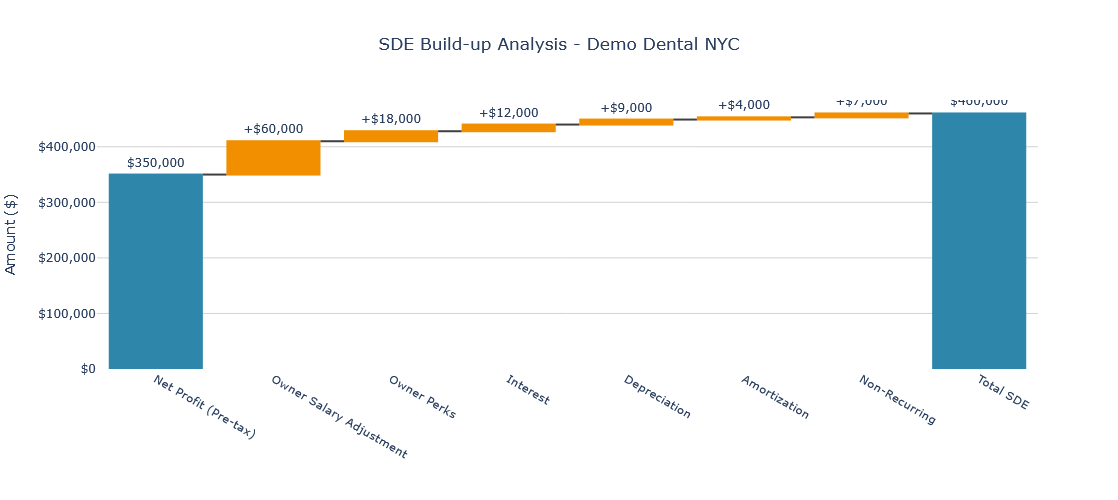

   ✅ SDE Waterfall created

2. Creating Valuation Comparison Chart...
   Purpose: Shows practice value using different methods


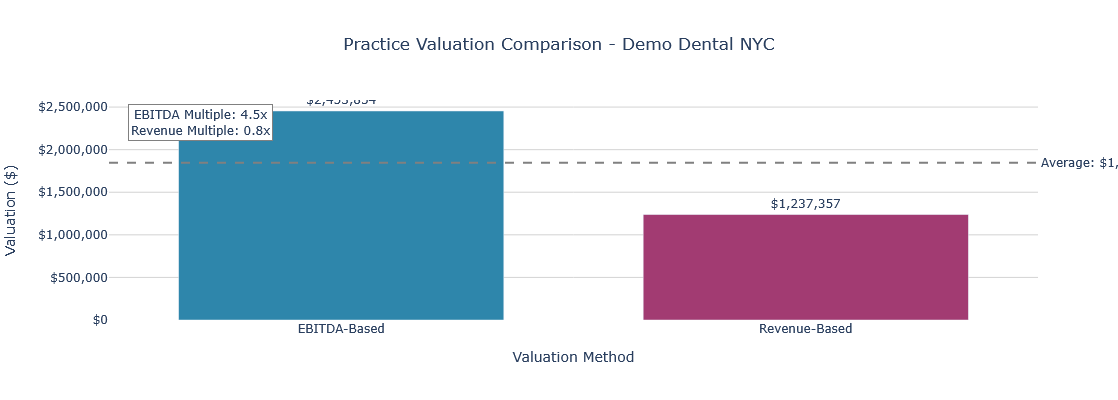

   ✅ Valuation Comparison created

3. Creating Key Metrics Dashboard...
   Purpose: One-page overview of all key metrics


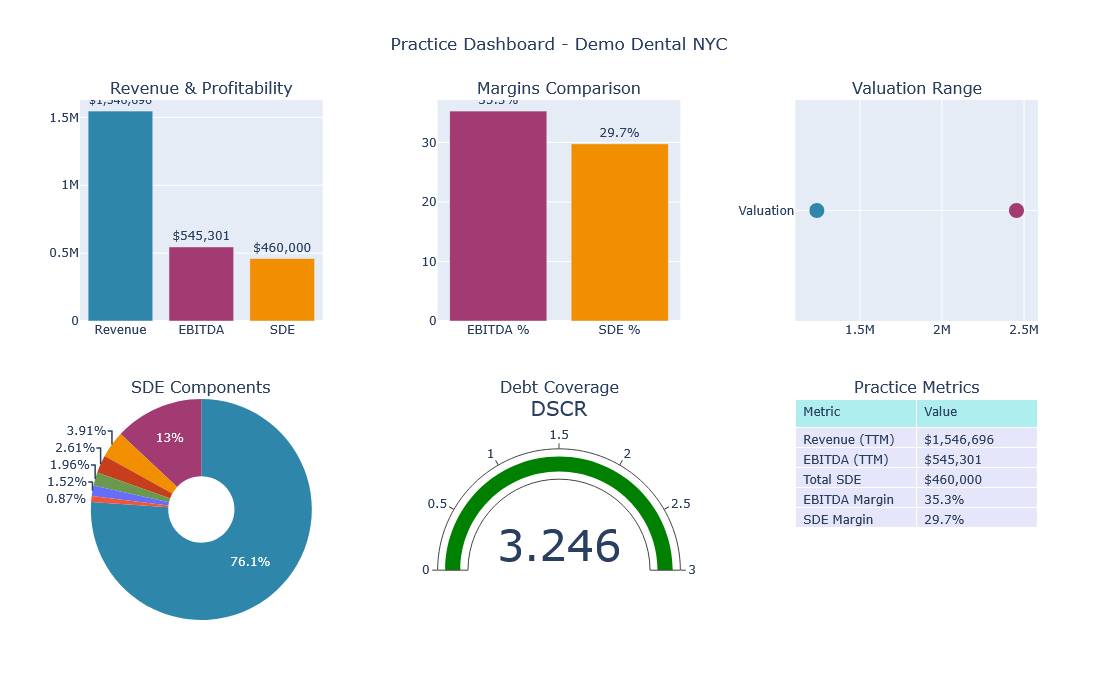

   ✅ Dashboard created

✅ Visualization module ready!

Available visualization types:
  • waterfall - SDE build-up analysis (shows profit adjustments)
  • bar_comparison - Valuation methods comparison (EBITDA vs Revenue)
  • bar_chart - Profitability margins (practice vs industry)
  • swot_matrix - SWOT analysis grid (strengths/weaknesses/opportunities/threats)
  • gauge_chart - Debt coverage ratio (financial health indicator)
  • dashboard - Complete metrics overview (6-panel summary)


In [17]:
# Cell 5: Visualization Generation Functions
# ===========================================

def create_sde_waterfall_chart(practice_data: DentalPracticeData):
    """
    Creates a WATERFALL CHART showing how SDE (Seller's Discretionary Earnings) is calculated.
    
    WHAT IS SDE?
    - SDE is the "true" profit available to a practice owner
    - It's what the owner actually takes home + what they could take home
    - Banks use SDE to determine if a buyer can afford to purchase the practice
    
    WHAT IS A WATERFALL CHART?
    - Shows step-by-step how we get from one number to another
    - Each bar adds to (green) or subtracts from (red) the total
    - Like climbing stairs - each step takes you higher (or lower)
    
    HOW TO READ THIS CHART:
    1. Start with Net Profit (what the tax return shows)
    2. Add back owner's excess salary (owner pays themselves above market rate)
    3. Add back owner perks (personal car, phone, etc. paid by business)
    4. Add back interest (buyer will have different financing)
    5. Add back depreciation (non-cash expense for tax purposes)
    6. Add back amortization (another non-cash expense)
    7. Add back one-time expenses (won't happen again)
    8. Final bar shows Total SDE
    
    WHY THIS MATTERS:
    - Shows the "real" earning power of the practice
    - Helps buyers understand what cash flow they can expect
    - Banks require this for loan approval
    
    Parameters:
    - practice_data: The DentalPracticeData object containing all financial info
    
    Returns:
    - Interactive Plotly chart that users can hover over for details
    """
    
    # Get SDE components from the data
    sde_components = practice_data.data.get("SDE", {})
    
    # Build the waterfall data
    # Each item needs: name, measure type, and value
    waterfall_data = []
    
    # Starting point: Net Profit (what's on the tax return)
    waterfall_data.append({
        'name': 'Net Profit (Pre-tax)',
        'measure': 'absolute',  # This is our starting point
        'value': sde_components.get('Net_Profit_pre_tax', 0),
        'text': f"${sde_components.get('Net_Profit_pre_tax', 0):,.0f}"
    })
    
    # Add each adjustment (these are "add-backs" - amounts we add back to profit)
    adjustments = [
        ('Owner Salary Adjustment', 'Owner_Salary_minus_Market'),  # Owner overpays themselves
        ('Owner Perks', 'Owner_Perks'),                           # Personal expenses in business
        ('Interest', 'Interest'),                                 # Current loan interest
        ('Depreciation', 'Depreciation'),                        # Non-cash tax deduction
        ('Amortization', 'Amortization'),                        # Non-cash tax deduction
        ('Non-Recurring', 'Non_Recurring')                       # One-time expenses
    ]
    
    for display_name, data_key in adjustments:
        value = sde_components.get(data_key, 0)
        if value > 0:  # Only add if there's a value
            waterfall_data.append({
                'name': display_name,
                'measure': 'relative',  # These add to the total
                'value': value,
                'text': f"+${value:,.0f}"
            })
    
    # Final total (this is what the practice really earns)
    waterfall_data.append({
        'name': 'Total SDE',
        'measure': 'total',  # This shows the final sum
        'value': practice_data.data.get('Total_SDE', 0),
        'text': f"${practice_data.data.get('Total_SDE', 0):,.0f}"
    })
    
    # Create the waterfall chart using Plotly
    fig = go.Figure(go.Waterfall(
        name="SDE Build-up",
        orientation="v",  # Vertical bars
        x=[d['name'] for d in waterfall_data],
        y=[d['value'] if d['measure'] != 'total' else None for d in waterfall_data],
        text=[d['text'] for d in waterfall_data],
        textposition="outside",
        measure=[d['measure'] for d in waterfall_data],
        connector={"line": {"color": "rgb(63, 63, 63)"}},  # Lines connecting bars
        increasing={"marker": {"color": VIZ_CONFIG['color_scheme'][2]}},  # Green for additions
        decreasing={"marker": {"color": VIZ_CONFIG['color_scheme'][3]}},  # Red for subtractions
        totals={"marker": {"color": VIZ_CONFIG['color_scheme'][0]}}  # Blue for totals
    ))
    
    # Update layout for better appearance
    fig.update_layout(
        title={
            'text': f"SDE Build-up Analysis - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        },
        yaxis_title="Amount ($)",
        xaxis_title="",
        height=500,
        showlegend=False,
        hovermode='x unified',
        plot_bgcolor='white',
        yaxis=dict(gridcolor='lightgray', tickformat='$,.0f')
    )
    
    return fig

def create_valuation_comparison_chart(practice_data: DentalPracticeData):
    """
    Creates a BAR CHART comparing different methods of valuing the practice.
    
    WHAT IS PRACTICE VALUATION?
    - The estimated selling price of the dental practice
    - Like appraising a house - there are different methods
    - Usually results in a range, not a single number
    
    TWO MAIN VALUATION METHODS:
    1. EBITDA Multiple Method:
       - Takes EBITDA (earnings) × industry multiple (typically 3-6x)
       - More accurate because it's based on profitability
       - Preferred by sophisticated buyers
    
    2. Revenue Multiple Method:
       - Takes total revenue × industry multiple (typically 0.6-1.0x)
       - Simpler but less accurate
       - Quick "rule of thumb" estimate
    
    HOW TO READ THIS CHART:
    - Two bars showing the practice value using each method
    - Dotted line shows the average of both methods
    - Higher bar = higher valuation
    - The gap between bars shows negotiation range
    
    WHY THIS MATTERS:
    - Sellers want to know what their practice is worth
    - Buyers need to know if the asking price is fair
    - Banks use these multiples for loan decisions
    - Wide gaps suggest more negotiation needed
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - Interactive bar chart comparing valuations
    """
    
    # Get valuation data (calculated in the data loading step)
    valuations = {
        'EBITDA-Based': practice_data.metrics.get('Implied_Value_EBITDA', 0),
        'Revenue-Based': practice_data.metrics.get('Implied_Value_Revenue', 0)
    }
    
    # Calculate average for reference (midpoint of the range)
    avg_valuation = sum(valuations.values()) / len(valuations)
    
    # Create bar chart
    fig = go.Figure()
    
    # Add bars for each valuation method
    fig.add_trace(go.Bar(
        x=list(valuations.keys()),
        y=list(valuations.values()),
        text=[f"${v:,.0f}" for v in valuations.values()],  # Show dollar amounts on bars
        textposition='outside',
        marker_color=[VIZ_CONFIG['color_scheme'][0], VIZ_CONFIG['color_scheme'][1]],
        name='Valuation'
    ))
    
    # Add average line for reference (helps show the midpoint)
    fig.add_hline(
        y=avg_valuation, 
        line_dash="dash", 
        line_color="gray",
        annotation_text=f"Average: ${avg_valuation:,.0f}",
        annotation_position="right"
    )
    
    # Update layout
    fig.update_layout(
        title={
            'text': f"Practice Valuation Comparison - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        },
        yaxis_title="Valuation ($)",
        xaxis_title="Valuation Method",
        height=400,
        showlegend=False,
        plot_bgcolor='white',
        yaxis=dict(gridcolor='lightgray', tickformat='$,.0f'),
        bargap=0.3  # Space between bars
    )
    
    # Add annotation box explaining the multiples used
    multiples = practice_data.data.get('Valuation_Multiples', {})
    fig.add_annotation(
        text=f"EBITDA Multiple: {multiples.get('EBITDA_multiple', 0)}x<br>" +
             f"Revenue Multiple: {multiples.get('Revenue_multiple', 0)}x",
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        showarrow=False,
        bgcolor="white",
        bordercolor="gray",
        borderwidth=1
    )
    
    return fig

def create_profitability_margins_chart(practice_data: DentalPracticeData):
    """
    Creates a GROUPED BAR CHART showing profitability margins vs industry averages.
    
    WHAT ARE MARGINS?
    - Margins show what percentage of revenue becomes profit
    - Like a grade on efficiency - higher is better
    - Shows how well the practice controls costs
    
    TWO KEY MARGINS:
    1. EBITDA Margin:
       - (EBITDA ÷ Revenue) × 100
       - Shows operating efficiency
       - Typical dental: 30-40%
    
    2. SDE Margin:
       - (SDE ÷ Revenue) × 100
       - Shows true owner benefit
       - Typical dental: 25-35%
    
    HOW TO READ THIS CHART:
    - Blue bars = This practice's actual margins
    - Gray bars = Industry average margins
    - Higher bars = better profitability
    - If blue > gray, practice is above average
    
    WHY THIS MATTERS:
    - High margins = well-run practice
    - Low margins = potential problems or opportunities
    - Buyers pay more for high-margin practices
    - Shows where improvements can be made
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - Grouped bar chart comparing margins
    """
    
    # Get this practice's margins
    margins = {
        'EBITDA Margin': practice_data.metrics.get('EBITDA_Margin', 0),
        'SDE Margin': practice_data.metrics.get('SDE_Margin', 0)
    }
    
    # Industry benchmarks for comparison (typical dental practice ranges)
    # These are rough averages - actual benchmarks vary by location/specialty
    benchmarks = {
        'EBITDA Margin': 35,  # Industry average EBITDA margin
        'SDE Margin': 30      # Industry average SDE margin
    }
    
    # Create grouped bar chart
    fig = go.Figure()
    
    # This practice's actual margins
    fig.add_trace(go.Bar(
        name='This Practice',
        x=list(margins.keys()),
        y=list(margins.values()),
        text=[f"{v:.1f}%" for v in margins.values()],
        textposition='outside',
        marker_color=VIZ_CONFIG['color_scheme'][0]
    ))
    
    # Industry benchmark margins
    fig.add_trace(go.Bar(
        name='Industry Avg',
        x=list(benchmarks.keys()),
        y=list(benchmarks.values()),
        text=[f"{v:.0f}%" for v in benchmarks.values()],
        textposition='outside',
        marker_color=VIZ_CONFIG['color_scheme'][4],
        opacity=0.6  # Make slightly transparent
    ))
    
    # Update layout
    fig.update_layout(
        title={
            'text': f"Profitability Margins Analysis - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        },
        yaxis_title="Margin (%)",
        xaxis_title="",
        height=400,
        barmode='group',  # Put bars side by side
        plot_bgcolor='white',
        yaxis=dict(gridcolor='lightgray', tickformat='.0f', ticksuffix='%'),
        legend=dict(orientation="h", y=1.1, x=0.5, xanchor='center')
    )
    
    return fig

def create_swot_matrix(practice_data: DentalPracticeData):
    """
    Creates a SWOT ANALYSIS MATRIX - a 2x2 grid showing strategic position.
    
    WHAT IS SWOT?
    S.W.O.T. stands for:
    - Strengths: What the practice does well (internal positive)
    - Weaknesses: What needs improvement (internal negative)
    - Opportunities: External factors that could help growth
    - Threats: External factors that could hurt the practice
    
    HOW TO READ THIS CHART:
    - Top row (Strengths & Weaknesses) = Internal factors (can control)
    - Bottom row (Opportunities & Threats) = External factors (can't control)
    - Left column (Strengths & Opportunities) = Positive factors
    - Right column (Weaknesses & Threats) = Negative factors
    
    WHY THIS MATTERS:
    - Buyers see the full picture of the practice
    - Identifies growth potential (opportunities)
    - Shows risks that need managing (threats)
    - Helps justify the asking price
    - Guides post-acquisition strategy
    
    EXAMPLE INTERPRETATIONS:
    - Many strengths + opportunities = Premium valuation
    - Several weaknesses = Buyer may negotiate lower price
    - Unaddressed threats = Risk factors affecting value
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - 2x2 matrix visualization (static matplotlib figure)
    """
    
    swot_data = practice_data.data.get('SWOT', {})
    
    # Create figure with 2x2 subplots (4 quadrants)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'SWOT Analysis - {practice_data.data.get("Clinic", "Dental Practice")}', 
                 fontsize=16, fontweight='bold')
    
    # Define quadrants with their data and colors
    # Green for strengths (positive), Red for weaknesses (negative)
    # Blue for opportunities (potential), Orange for threats (risks)
    quadrants = [
        ('Strengths', swot_data.get('Strengths', []), axes[0, 0], VIZ_CONFIG['color_scheme'][2]),
        ('Weaknesses', swot_data.get('Weaknesses', []), axes[0, 1], VIZ_CONFIG['color_scheme'][3]),
        ('Opportunities', swot_data.get('Opportunities', []), axes[1, 0], VIZ_CONFIG['color_scheme'][1]),
        ('Threats', swot_data.get('Threats', []), axes[1, 1], VIZ_CONFIG['color_scheme'][0])
    ]
    
    # Fill each quadrant
    for title, items, ax, color in quadrants:
        # Set background color (light version with transparency)
        ax.set_facecolor(color + '20')  # Add transparency
        
        # Add quadrant title
        ax.text(0.5, 0.9, title, fontsize=14, fontweight='bold',
                ha='center', transform=ax.transAxes)
        
        # Add items as bullet points
        y_position = 0.7
        for item in items[:5]:  # Limit to 5 items per quadrant for readability
            ax.text(0.1, y_position, f'• {item}', fontsize=11,
                   transform=ax.transAxes, wrap=True)
            y_position -= 0.15
        
        # Remove axes for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2)
    
    plt.tight_layout()
    return fig

def create_debt_coverage_gauge(practice_data: DentalPracticeData):
    """
    Creates a GAUGE CHART showing Debt Service Coverage Ratio (DSCR).
    
    WHAT IS DSCR?
    - Debt Service Coverage Ratio
    - Formula: EBITDA ÷ Annual Debt Payments
    - Shows if practice generates enough cash to pay its loans
    - Banks require minimum DSCR of 1.2-1.25 for loans
    
    HOW TO READ THIS GAUGE:
    - Red Zone (0-1.0): DANGER - Cannot cover debt payments
    - Yellow Zone (1.0-1.25): CAUTION - Tight coverage, risky
    - Green Zone (1.25+): GOOD - Comfortable debt coverage
    
    WHAT THE NUMBERS MEAN:
    - DSCR = 1.0: Breaking even on debt (no cushion)
    - DSCR = 1.25: Have 25% cushion above debt payments
    - DSCR = 2.0: Generate 2x the cash needed for debt
    
    WHY THIS MATTERS:
    - Banks won't lend if DSCR < 1.2
    - Low DSCR = practice is overleveraged
    - High DSCR = room for more debt or distributions
    - Critical metric for buyer financing approval
    
    BUYER IMPLICATIONS:
    - DSCR < 1.0: Need to inject cash or renegotiate debt
    - DSCR 1.0-1.25: Limited cash for owner or growth
    - DSCR > 1.25: Healthy cash flow after debt service
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - Gauge chart visualization (like a speedometer)
    """
    
    dscr = practice_data.metrics.get('DSCR', 0)
    
    # Create gauge chart
    fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=dscr,
        title={'text': "Debt Service Coverage Ratio"},
        delta={'reference': 1.25, 'relative': False},  # Compare to healthy threshold
        gauge={
            'axis': {'range': [0, 3], 'tickwidth': 1},
            'bar': {'color': "darkblue"},  # The needle color
            'steps': [  # Background zones
                {'range': [0, 1], 'color': "lightgray"},        # Can't cover debt
                {'range': [1, 1.25], 'color': "lightyellow"},   # Tight coverage
                {'range': [1.25, 3], 'color': "lightgreen"}     # Healthy coverage
            ],
            'threshold': {  # Red line at minimum viable level
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': 1  # Minimum viable DSCR
            }
        }
    ))
    
    # Update layout
    fig.update_layout(
        height=400,
        title={
            'text': f"Debt Coverage Analysis - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        }
    )
    
    # Add interpretation text based on DSCR value
    if dscr < 1:
        interpretation = "⚠️ Warning: Insufficient cash flow to cover debt payments"
    elif dscr < 1.25:
        interpretation = "⚡ Caution: Tight debt coverage - limited margin for error"
    else:
        interpretation = "✅ Healthy: Strong debt coverage with comfortable cushion"
    
    fig.add_annotation(
        text=interpretation,
        xref="paper", yref="paper",
        x=0.5, y=-0.1,
        showarrow=False,
        font=dict(size=12)
    )
    
    return fig

def create_key_metrics_dashboard(practice_data: DentalPracticeData):
    """
    Creates a COMPREHENSIVE DASHBOARD with 6 panels of key information.
    
    WHAT IS THIS DASHBOARD?
    - A one-page overview of all critical practice metrics
    - Like a car dashboard - shows everything at a glance
    - Used for initial assessment and presentations
    
    THE 6 PANELS:
    1. Revenue & Profitability: Size and earnings of practice
    2. Margins Comparison: Efficiency vs industry
    3. Valuation Range: What the practice is worth
    4. SDE Components: Where the profit comes from
    5. Debt Coverage: Financial health indicator
    6. Practice Metrics: Key operational data
    
    HOW TO USE THIS:
    - First thing to show potential buyers
    - Quick health check of the practice
    - Identifies areas needing deeper analysis
    - Executive summary for decision makers
    
    WHY THIS MATTERS:
    - Saves time by showing everything at once
    - Helps identify red flags quickly
    - Provides context for detailed discussions
    - Professional presentation for stakeholders
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - Multi-panel Plotly dashboard
    """
    
    # Create subplots with different chart types
    fig = make_subplots(
        rows=2, cols=3,  # 2 rows, 3 columns = 6 panels
        subplot_titles=(
            'Revenue & Profitability',  # Shows practice size
            'Margins Comparison',        # Shows efficiency
            'Valuation Range',          # Shows worth
            'SDE Components',           # Shows profit makeup
            'Debt Coverage',            # Shows financial health
            'Practice Metrics'          # Shows key numbers
        ),
        specs=[  # Define what type of chart goes in each position
            [{'type': 'bar'}, {'type': 'bar'}, {'type': 'scatter'}],
            [{'type': 'pie'}, {'type': 'indicator'}, {'type': 'table'}]
        ],
        vertical_spacing=0.15,
        horizontal_spacing=0.12
    )
    
    # 1. Revenue & Profitability bars (top-left)
    # Shows the cascade from revenue → EBITDA → SDE
    fig.add_trace(
        go.Bar(
            x=['Revenue', 'EBITDA', 'SDE'],
            y=[
                practice_data.data.get('Revenue_Trailing12', 0),
                practice_data.data.get('EBITDA_Trailing12', 0),
                practice_data.data.get('Total_SDE', 0)
            ],
            text=[
                f"${practice_data.data.get('Revenue_Trailing12', 0):,.0f}",
                f"${practice_data.data.get('EBITDA_Trailing12', 0):,.0f}",
                f"${practice_data.data.get('Total_SDE', 0):,.0f}"
            ],
            textposition='outside',
            marker_color=VIZ_CONFIG['color_scheme'][:3]
        ),
        row=1, col=1
    )
    
    # 2. Margins comparison (top-middle)
    # Shows profitability percentages
    fig.add_trace(
        go.Bar(
            x=['EBITDA %', 'SDE %'],
            y=[
                practice_data.metrics.get('EBITDA_Margin', 0),
                practice_data.metrics.get('SDE_Margin', 0)
            ],
            text=[
                f"{practice_data.metrics.get('EBITDA_Margin', 0):.1f}%",
                f"{practice_data.metrics.get('SDE_Margin', 0):.1f}%"
            ],
            textposition='outside',
            marker_color=[VIZ_CONFIG['color_scheme'][1], VIZ_CONFIG['color_scheme'][2]]
        ),
        row=1, col=2
    )
    
    # 3. Valuation range (top-right)
    # Shows the spread between valuation methods
    valuations = [
        practice_data.metrics.get('Implied_Value_Revenue', 0),
        practice_data.metrics.get('Implied_Value_EBITDA', 0)
    ]
    fig.add_trace(
        go.Scatter(
            x=valuations,
            y=['Valuation', 'Valuation'],
            mode='markers',
            marker=dict(size=15, color=VIZ_CONFIG['color_scheme'][:2]),
            text=[f"Revenue: ${valuations[0]:,.0f}", f"EBITDA: ${valuations[1]:,.0f}"],
            showlegend=False
        ),
        row=1, col=3
    )
    
    # 4. SDE Components pie chart (bottom-left)
    # Shows what makes up the SDE
    sde_components = practice_data.data.get('SDE', {})
    fig.add_trace(
        go.Pie(
            labels=list(sde_components.keys()),
            values=list(sde_components.values()),
            hole=0.3,  # Donut chart
            marker_colors=VIZ_CONFIG['color_scheme']
        ),
        row=2, col=1
    )
    
    # 5. Debt Coverage gauge (bottom-middle)
    # Quick visual of DSCR health
    dscr = practice_data.metrics.get('DSCR', 0)
    fig.add_trace(
        go.Indicator(
            mode="number+gauge",
            value=dscr,
            gauge={'axis': {'range': [0, 3]},
                   'bar': {'color': "green" if dscr > 1.25 else "yellow" if dscr > 1 else "red"}},
            title={'text': "DSCR"}
        ),
        row=2, col=2
    )
    
    # 6. Key metrics table (bottom-right)
    # Quick reference for important numbers
    summary_df = practice_data.get_summary()
    fig.add_trace(
        go.Table(
            header=dict(values=['Metric', 'Value'],
                       fill_color='paleturquoise',
                       align='left'),
            cells=dict(values=[summary_df['Metric'][:5], summary_df['Value'][:5]],
                      fill_color='lavender',
                      align='left')
        ),
        row=2, col=3
    )
    
    # Update overall layout
    fig.update_layout(
        title={
            'text': f"Practice Dashboard - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        },
        height=700,
        showlegend=False
    )
    
    return fig

def generate_visualization(viz_type: str, practice_data: DentalPracticeData):
    """
    Main routing function that generates any visualization based on type.
    This is the function you call when you need a specific chart.
    
    HOW TO USE:
    figure = generate_visualization('waterfall', practice_data)
    figure.show()  # Display the chart
    
    AVAILABLE VISUALIZATION TYPES:
    - 'waterfall': SDE build-up from Net Profit
    - 'bar_comparison': Valuation methods comparison  
    - 'bar_chart': Profitability margins vs industry
    - 'swot_matrix': 2x2 SWOT analysis grid
    - 'gauge_chart': Debt coverage ratio gauge
    - 'dashboard': Complete 6-panel overview
    
    Parameters:
    - viz_type: String specifying which chart to create
    - practice_data: The DentalPracticeData object with all info
    
    Returns:
    - Figure object that can be displayed or saved
    - Returns None if there's an error
    """
    
    # Map visualization types to their creation functions
    viz_functions = {
        'waterfall': create_sde_waterfall_chart,
        'bar_comparison': create_valuation_comparison_chart,
        'bar_chart': create_profitability_margins_chart,
        'swot_matrix': create_swot_matrix,
        'gauge_chart': create_debt_coverage_gauge,
        'dashboard': create_key_metrics_dashboard
    }
    
    # Get the appropriate function for the requested type
    viz_function = viz_functions.get(viz_type)
    
    if viz_function:
        try:
            return viz_function(practice_data)
        except Exception as e:
            print(f"❌ Error creating {viz_type}: {str(e)}")
            return None
    else:
        print(f"⚠️ Unknown visualization type: {viz_type}")
        return None

# ===================================
# TEST VISUALIZATIONS
# ===================================

# Make sure we have practice data loaded
if 'practice_data' not in locals():
    print("⚠️ Loading practice data first...")
    practice_data = DentalPracticeData(json_path="demo_clinic.json")

print("="*60)
print("🎨 TESTING VISUALIZATION FUNCTIONS")
print("="*60)

# Test 1: SDE Waterfall Chart
# This shows how profit builds up to SDE
print("\n1. Creating SDE Waterfall Chart...")
print("   Purpose: Shows step-by-step how Net Profit becomes SDE")
fig1 = create_sde_waterfall_chart(practice_data)
if fig1:
    fig1.show()
    print("   ✅ SDE Waterfall created")

# Test 2: Valuation Comparison
# This compares different ways to value the practice
print("\n2. Creating Valuation Comparison Chart...")
print("   Purpose: Shows practice value using different methods")
fig2 = create_valuation_comparison_chart(practice_data)
if fig2:
    fig2.show()
    print("   ✅ Valuation Comparison created")

# Test 3: Dashboard
# This gives the complete overview in one view
print("\n3. Creating Key Metrics Dashboard...")
print("   Purpose: One-page overview of all key metrics")
fig3 = create_key_metrics_dashboard(practice_data)
if fig3:
    fig3.show()
    print("   ✅ Dashboard created")

print("\n" + "="*60)
print("✅ Visualization module ready!")
print("\nAvailable visualization types:")
print("  • waterfall - SDE build-up analysis (shows profit adjustments)")
print("  • bar_comparison - Valuation methods comparison (EBITDA vs Revenue)")
print("  • bar_chart - Profitability margins (practice vs industry)")
print("  • swot_matrix - SWOT analysis grid (strengths/weaknesses/opportunities/threats)")
print("  • gauge_chart - Debt coverage ratio (financial health indicator)")
print("  • dashboard - Complete metrics overview (6-panel summary)")
print("="*60)


🚀 DENTAL PRACTICE VALUATION Q&A PIPELINE READY!

📌 DEMO: Processing a sample question...
Question: 'What is the SDE for this practice and explain how it's calculated?'
----------------------------------------------------------------------

🦷 DENTAL PRACTICE VALUATION Q&A SYSTEM
⏰ Timestamp: 2025-08-07 18:36:19
📝 Question: What is the SDE for this practice and explain how it's calculated?
----------------------------------------------------------------------
📊 Category detected: SDE
🤖 Getting AI analysis...
🤖 Calling DeepSeek API...
✅ Response received!
📈 Creating 1 visualization(s)...
   - Creating SDE Build-up Analysis...


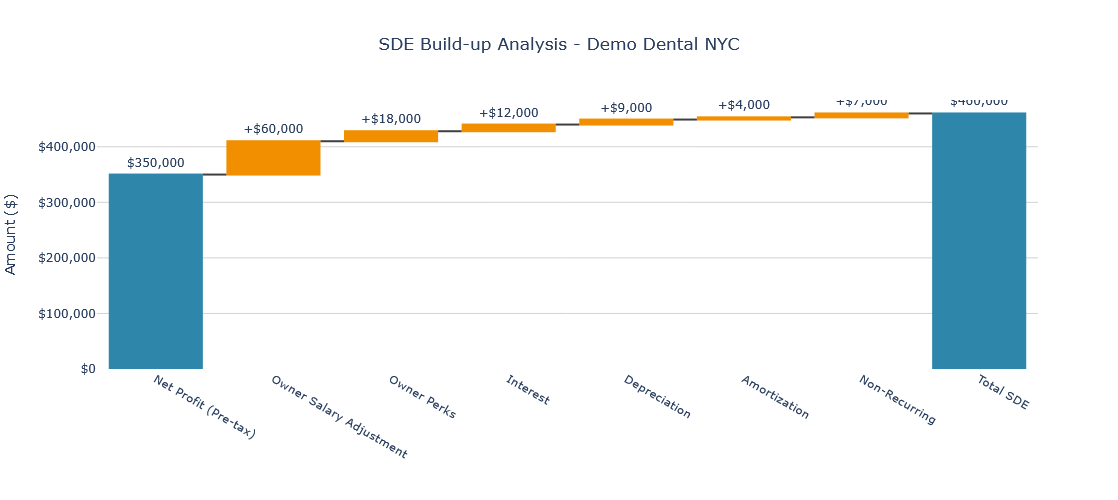

----------------------------------------------------------------------
✅ Question processed successfully!



### 📝 Question
**What is the SDE for this practice and explain how it's calculated?**

---

### 📊 Analysis Category
`SDE`

---

### 💡 Answer
### **Seller's Discretionary Earnings (SDE) Analysis for Demo Dental NYC**  

#### **1. Definition of SDE**  
Seller's Discretionary Earnings (SDE) represents the total financial benefit a single owner-operator derives from the practice, including both profits and discretionary expenses. It is a key metric for valuing small to mid-sized dental practices.  

#### **2. SDE Calculation Breakdown**  
The SDE for **Demo Dental NYC** is **$460,000**, calculated as follows:  

| **Component**                     | **Amount ($)** | **Type**  | **Justification** |
|-----------------------------------|---------------|-----------|------------------|
| Net Profit (Pre-Tax)              | 350,000       | Cash      | Base accounting profit before tax adjustments. |
| + Owner Salary Above Market       | 60,000        | Cash      | Portion of the owner's salary exceeding fair-market compensation for a dentist in NYC. |
| + Owner Perks                     | 18,000        | Cash      | Clinic-paid personal expenses (auto, phone, family health insurance). |
| + Interest Expense                | 12,000        | Cash      | Financing costs—assumed refinanced by buyer. |
| + Depreciation                    | 9,000         | Non-Cash  | Non-cash accounting expense (equipment wear & tear). |
| + Amortization                    | 4,000         | Non-Cash  | Non-cash expense (prior goodwill amortization). |
| + Non-Recurring Expense           | 7,000         | Cash      | One-time legal settlement (FY 2024). |
| **Total SDE**                     | **460,000**   |           | **Sum of all adjustments to net profit.** |

#### **3. Key Observations**  
- **Cash vs. Non-Cash Adjustments:**  
  - **Cash Addbacks ($97,000 total):**  
    - Owner salary above market ($60K)  
    - Owner perks ($18K)  
    - Interest ($12K)  
    - Non-recurring expense ($7K)  
  - **Non-Cash Addbacks ($13,000 total):**  
    - Depreciation ($9K)  
    - Amortization ($4K)  

- **SDE Margin:**  
  - **29.7%** ($460K SDE / $1,546,696 Revenue)  
  - **Industry Benchmark:** Typically 25-40% for well-run FFS practices. Demo Dental is in the upper range, indicating strong profitability.  

#### **4. Visualizations That Would Help**  
To better illustrate the SDE composition, the following visuals would be useful:  
1. **SDE Breakdown Pie Chart** – Showing the contribution of each addback component.  
2. **Cash vs. Non-Cash Addbacks Bar Chart** – Highlighting the split between real cash savings and accounting adjustments.  
3. **SDE Margin Trend (if historical data available)** – To assess profitability consistency.  

#### **5. Valuation Implications**  
- **SDE-Based Valuation:** Using a typical multiple of **4.0x–5.0x SDE**, the practice could be valued between **$1.84M–$2.3M**.  
- **EBITDA vs. SDE:** Since SDE includes owner compensation, it is typically higher than EBITDA ($545K vs. $460K).  

#### **Conclusion**  
Demo Dental NYC generates a strong **$460K SDE**, supported by high FFS revenue and efficient operations. The addbacks are well-justified, with a healthy mix of cash and non-cash adjustments. Buyers should focus on maintaining the high SDE margin while exploring growth opportunities (e.g., expanded hours, implant services).  

Would you like further breakdowns on valuation multiples or debt service coverage?

---

### 📈 Visualizations Generated
- **SDE Build-up Analysis**: Shows how we get from Net Profit to SDE

---
*Generated: 2025-08-07 18:36:19*


📚 AVAILABLE FUNCTIONS:

1. process_question_with_visualizations()
   - Main pipeline function
   - Takes question → returns answer + visualizations
   
2. run_interactive_qa_session()
   - Interactive mode for multiple questions
   - Type questions one at a time
   
3. batch_process_questions()
   - Process multiple questions at once
   - Generate comprehensive reports

4. Common question examples:
   - "What is this practice worth?"
   - "Can the practice support its debt?"
   - "How does profitability compare to industry?"
   - "What are the key risks and opportunities?"
   - "Calculate the buyer's after-tax cash flow"


💡 TIP: To start an interactive session, run:
   run_interactive_qa_session(practice_data)

✅ System fully integrated and ready for use!


In [19]:
# Cell 6: Main Pipeline Integration
# ===================================
# This cell brings everything together into a complete Q&A system

def process_question_with_visualizations(
    question: str, 
    practice_data: DentalPracticeData,
    show_visualizations: bool = True,
    save_outputs: bool = False,
    output_dir: str = "valuation_outputs"
) -> dict:
    """
    MAIN PIPELINE FUNCTION - This is the complete system in one function.
    Takes a question and returns an answer with relevant visualizations.
    
    WHAT THIS DOES:
    1. Accepts a question about the dental practice
    2. Categorizes the question type
    3. Gets an intelligent answer from the LLM
    4. Creates relevant visualizations
    5. Optionally saves everything to files
    
    Parameters:
    - question: The user's question (string)
    - practice_data: The loaded practice data object
    - show_visualizations: Whether to display charts (default True)
    - save_outputs: Whether to save results to files (default False)
    - output_dir: Directory to save outputs if save_outputs=True
    
    Returns:
    - Dictionary containing:
      - 'question': Original question
      - 'category': Detected question type
      - 'answer': LLM's detailed response
      - 'visualizations': List of generated charts
      - 'timestamp': When the question was processed
      - 'files_saved': List of saved file paths (if save_outputs=True)
    """
    
    import os
    from datetime import datetime
    
    # Record when this question was processed
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    print("\n" + "="*70)
    print("🦷 DENTAL PRACTICE VALUATION Q&A SYSTEM")
    print("="*70)
    print(f"⏰ Timestamp: {timestamp}")
    print(f"📝 Question: {question}")
    print("-"*70)
    
    # Step 1: Categorize the question
    category = categorize_question(question)
    print(f"📊 Category detected: {category}")
    
    # Step 2: Get LLM answer
    print("🤖 Getting AI analysis...")
    prompt = create_context_prompt(practice_data, question, category)
    answer = call_llm(prompt)
    
    # Step 3: Get visualization recommendations
    viz_recommendations = get_visualization_recommendations(question, category, practice_data)
    
    # Step 4: Generate visualizations
    generated_visualizations = []
    print(f"📈 Creating {len(viz_recommendations)} visualization(s)...")
    
    for viz_rec in viz_recommendations:
        viz_type = viz_rec['type']
        print(f"   - Creating {viz_rec['title']}...")
        
        try:
            fig = generate_visualization(viz_type, practice_data)
            if fig:
                generated_visualizations.append({
                    'type': viz_type,
                    'title': viz_rec['title'],
                    'description': viz_rec['description'],
                    'figure': fig
                })
                
                # Display the visualization if requested
                if show_visualizations:
                    if hasattr(fig, 'show'):  # Plotly figure
                        fig.show()
                    else:  # Matplotlib figure
                        plt.show()
                        
        except Exception as e:
            print(f"   ⚠️ Could not create {viz_type}: {str(e)}")
    
    # Step 5: Save outputs if requested
    files_saved = []
    if save_outputs:
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate safe filename from timestamp
        safe_timestamp = timestamp.replace(":", "-").replace(" ", "_")
        
        # Save the Q&A as a markdown file
        qa_filename = os.path.join(output_dir, f"qa_{safe_timestamp}.md")
        with open(qa_filename, 'w') as f:
            f.write(f"# Dental Practice Valuation Q&A\n\n")
            f.write(f"**Practice:** {practice_data.data.get('Clinic', 'Unknown')}\n")
            f.write(f"**Date:** {timestamp}\n\n")
            f.write(f"## Question\n{question}\n\n")
            f.write(f"**Category:** {category}\n\n")
            f.write(f"## Answer\n{answer}\n\n")
            f.write(f"## Visualizations Created\n")
            for viz in generated_visualizations:
                f.write(f"- {viz['title']}: {viz['description']}\n")
        
        files_saved.append(qa_filename)
        print(f"   ✅ Saved Q&A to: {qa_filename}")
        
        # Save visualizations
        for i, viz in enumerate(generated_visualizations):
            fig = viz['figure']
            viz_filename = os.path.join(output_dir, f"viz_{i+1}_{viz['type']}_{safe_timestamp}")
            
            if hasattr(fig, 'write_html'):  # Plotly figure
                fig.write_html(f"{viz_filename}.html")
                files_saved.append(f"{viz_filename}.html")
                print(f"   ✅ Saved {viz['title']} to: {viz_filename}.html")
            else:  # Matplotlib figure
                fig.savefig(f"{viz_filename}.png", dpi=150, bbox_inches='tight')
                files_saved.append(f"{viz_filename}.png")
                print(f"   ✅ Saved {viz['title']} to: {viz_filename}.png")
    
    # Compile results
    result = {
        'question': question,
        'category': category,
        'answer': answer,
        'visualizations': generated_visualizations,
        'timestamp': timestamp,
        'files_saved': files_saved
    }
    
    print("-"*70)
    print("✅ Question processed successfully!")
    print("="*70)
    
    return result

def display_formatted_answer(result: dict):
    """
    Displays the Q&A result in a nicely formatted way for Jupyter notebooks.
    
    Parameters:
    - result: The dictionary returned by process_question_with_visualizations
    
    This creates a clean, professional display of the answer with:
    - Formatted markdown
    - Highlighted key metrics
    - Clear sections
    """
    
    from IPython.display import display, Markdown
    
    # Build formatted markdown output
    output = f"""
### 📝 Question
**{result['question']}**

---

### 📊 Analysis Category
`{result['category']}`

---

### 💡 Answer
{result['answer']}

---

### 📈 Visualizations Generated
"""
    
    for viz in result['visualizations']:
        output += f"- **{viz['title']}**: {viz['description']}\n"
    
    if result['files_saved']:
        output += f"\n---\n### 💾 Files Saved\n"
        for file in result['files_saved']:
            output += f"- `{file}`\n"
    
    output += f"\n---\n*Generated: {result['timestamp']}*"
    
    display(Markdown(output))

def run_interactive_qa_session(practice_data: DentalPracticeData):
    """
    Runs an interactive Q&A session where users can ask multiple questions.
    This is useful for demonstrations or training.
    
    Parameters:
    - practice_data: The loaded practice data
    
    How it works:
    - Prompts user for questions
    - Processes each question
    - Type 'quit' or 'exit' to stop
    """
    
    print("\n" + "="*70)
    print("🦷 INTERACTIVE DENTAL PRACTICE VALUATION Q&A")
    print("="*70)
    print(f"Practice: {practice_data.data.get('Clinic', 'Unknown')}")
    print("Type 'quit' or 'exit' to end the session")
    print("Type 'help' for example questions")
    print("="*70)
    
    # Example questions for users
    example_questions = [
        "What is the SDE for this practice and how is it calculated?",
        "What is this practice worth based on the valuation multiples?",
        "How do the margins compare to industry standards?",
        "Can this practice afford its debt payments?",
        "What are the main strengths and weaknesses?",
        "What's the after-tax cash flow for a buyer?",
        "Explain the EBITDA and how it relates to practice value",
        "What growth opportunities exist for this practice?"
    ]
    
    while True:
        print("\n")
        question = input("Enter your question (or 'help' for examples): ").strip()
        
        if question.lower() in ['quit', 'exit']:
            print("\n👋 Thank you for using the Dental Practice Valuation Q&A System!")
            break
        
        elif question.lower() == 'help':
            print("\n📚 Example Questions:")
            for i, q in enumerate(example_questions, 1):
                print(f"   {i}. {q}")
            continue
        
        elif question == "":
            print("⚠️ Please enter a question.")
            continue
        
        else:
            # Process the question
            result = process_question_with_visualizations(
                question=question,
                practice_data=practice_data,
                show_visualizations=True,
                save_outputs=False  # Change to True to save files
            )
            
            # Display formatted answer
            display_formatted_answer(result)

def batch_process_questions(
    questions: list,
    practice_data: DentalPracticeData,
    save_report: bool = True
) -> list:
    """
    Processes multiple questions at once and optionally creates a report.
    Useful for generating comprehensive practice assessments.
    
    Parameters:
    - questions: List of questions to process
    - practice_data: The loaded practice data
    - save_report: Whether to save a combined report
    
    Returns:
    - List of results for each question
    
    Use case:
    - Generate a standard report for every practice
    - Answer common buyer questions all at once
    - Create documentation for due diligence
    """
    
    results = []
    
    print("\n" + "="*70)
    print("📋 BATCH PROCESSING QUESTIONS")
    print("="*70)
    print(f"Processing {len(questions)} questions...")
    
    for i, question in enumerate(questions, 1):
        print(f"\n[{i}/{len(questions)}] Processing: {question[:50]}...")
        
        result = process_question_with_visualizations(
            question=question,
            practice_data=practice_data,
            show_visualizations=False,  # Don't show each chart
            save_outputs=False  # We'll save combined report instead
        )
        results.append(result)
    
    if save_report:
        # Create comprehensive report
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        report_filename = f"valuation_report_{timestamp}.md"
        
        with open(report_filename, 'w') as f:
            f.write(f"# Dental Practice Valuation Report\n\n")
            f.write(f"**Practice:** {practice_data.data.get('Clinic', 'Unknown')}\n")
            f.write(f"**Report Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write(f"---\n\n")
            
            # Add summary metrics
            f.write(f"## Executive Summary\n\n")
            f.write(f"- **Revenue (TTM):** ${practice_data.data.get('Revenue_Trailing12', 0):,.0f}\n")
            f.write(f"- **EBITDA (TTM):** ${practice_data.data.get('EBITDA_Trailing12', 0):,.0f}\n")
            f.write(f"- **Total SDE:** ${practice_data.data.get('Total_SDE', 0):,.0f}\n")
            f.write(f"- **EBITDA Margin:** {practice_data.metrics.get('EBITDA_Margin', 0):.1f}%\n")
            f.write(f"- **Implied Value (EBITDA):** ${practice_data.metrics.get('Implied_Value_EBITDA', 0):,.0f}\n")
            f.write(f"\n---\n\n")
            
            # Add each Q&A
            for i, result in enumerate(results, 1):
                f.write(f"## Question {i}\n\n")
                f.write(f"**{result['question']}**\n\n")
                f.write(f"### Answer\n{result['answer']}\n\n")
                f.write(f"---\n\n")
        
        print(f"\n✅ Report saved to: {report_filename}")
    
    print("\n" + "="*70)
    print(f"✅ Processed {len(results)} questions successfully!")
    
    return results

# ===================================
# DEMONSTRATION AND TESTING
# ===================================

# Make sure we have practice data loaded
if 'practice_data' not in locals():
    print("⚠️ Loading practice data first...")
    practice_data = DentalPracticeData(json_path="demo_clinic.json")

print("\n" + "="*70)
print("🚀 DENTAL PRACTICE VALUATION Q&A PIPELINE READY!")
print("="*70)

# Demonstrate with a sample question
demo_question = "What is the SDE for this practice and explain how it's calculated?"

print("\n📌 DEMO: Processing a sample question...")
print(f"Question: '{demo_question}'")
print("-"*70)

# Process the question
demo_result = process_question_with_visualizations(
    question=demo_question,
    practice_data=practice_data,
    show_visualizations=True,
    save_outputs=False  # Set to True to save files
)

# Display the formatted answer
display_formatted_answer(demo_result)

# Show available functions
print("\n" + "="*70)
print("📚 AVAILABLE FUNCTIONS:")
print("="*70)
print("""
1. process_question_with_visualizations()
   - Main pipeline function
   - Takes question → returns answer + visualizations
   
2. run_interactive_qa_session()
   - Interactive mode for multiple questions
   - Type questions one at a time
   
3. batch_process_questions()
   - Process multiple questions at once
   - Generate comprehensive reports

4. Common question examples:
   - "What is this practice worth?"
   - "Can the practice support its debt?"
   - "How does profitability compare to industry?"
   - "What are the key risks and opportunities?"
   - "Calculate the buyer's after-tax cash flow"
""")

print("\n💡 TIP: To start an interactive session, run:")
print("   run_interactive_qa_session(practice_data)")
print("\n✅ System fully integrated and ready for use!")
print("="*70)